In [2]:
%matplotlib inline

In [3]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
## Get  multiple outputs in the same shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

In [5]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [6]:
## Reading the datasets
# This might be present in S3, or obtained through a query on a database
df = pd.read_csv('data/Churn_Modelling.csv')

In [7]:
df.shape

(10000, 14)

In [8]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
RowNumber,1,2,3,4,5,6,7,8,9,10
CustomerId,15634602,15647311,15619304,15701354,15737888,15574012,15592531,15656148,15792365,15592389
Surname,Hargrave,Hill,Onio,Boni,Mitchell,Chu,Bartlett,Obinna,He,H?
CreditScore,619,608,502,699,850,645,822,376,501,684
Geography,France,Spain,France,France,Spain,Spain,France,Germany,France,France
Gender,Female,Female,Female,Female,Female,Male,Male,Female,Male,Male
Age,42,41,42,39,43,44,50,29,44,27
Tenure,2,1,8,1,2,8,7,4,4,2
Balance,0.0,83807.86,159660.8,0.0,125510.82,113755.78,0.0,115046.74,142051.07,134603.88
NumOfProducts,1,1,3,2,1,2,2,4,2,1


### Basic EDA

In [9]:
df.describe() #describe all numerical columns
df.describe(include = ['O']) # describe all non-numerical/categorical columns

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [10]:
## checking the unique customers in the dataset
df.shape[0], df['CustomerId'].nunique()

(10000, 10000)

In [11]:
df_t = df.groupby(['Surname']).agg({'RowNumber':'count','Exited':'mean'}).reset_index().sort_values(by='RowNumber', ascending=False)

In [12]:
df_t.head(5)

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


In [13]:
df.Geography.value_counts(normalize = True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

### Conclusion
    1. Discard row number;
    2. Discard CustomerId as well, since it doesn't convey any extra info. Each row pertains to a unique customer
    3. Based on the above, columns/features can be segregated into non-essential, numerical, categorical and target variables
In genral, CustomerId is a very useful feature on the basis of which we can calculate a lot of user-centruc features. Here, the datasets is not sufficient to calculate any extra customer features.
    

In [14]:
## Seperating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber','CustomerId']
num_feats = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
cat_feats = ['Surname', 'Geography','Gender','HasCrCard','IsActiveMember']

Among these, Tenure and NumberOfProducts are ordinarl variables. HasCrCard and IsActiveMember are actually binary categorical variables.

In [15]:
## Seperating out target variable and removing the non-enssential columns
y = df[target_var].values
df.drop(cols_to_remove, axis = 1, inplace = True)

### Seperating out train-test-valid sets

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
## Keeping aside a test/holdout set
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y.ravel(), test_size = 0.1, random_state = 42)

## Splitting into train and validation set
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size = 0.12, random_state =42)

In [18]:
df_train.shape, df_val.shape, df_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train),np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

### Univariate plots of numberical variables in training set

<AxesSubplot:ylabel='CreditScore'>

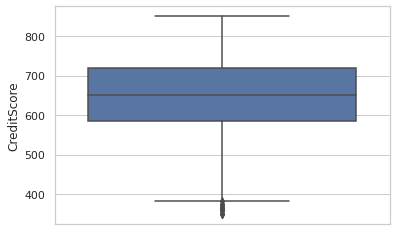

In [19]:
## CreditScore
sns.set(style="whitegrid")
sns.boxplot(y = df_train['CreditScore'])

<AxesSubplot:ylabel='Age'>

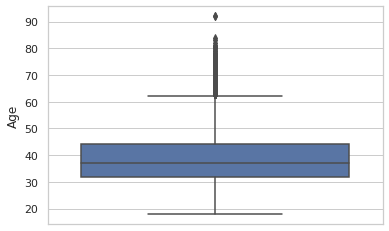

In [20]:
## Age
sns.boxplot(y = df_train['Age'])

<AxesSubplot:ylabel='Tenure'>

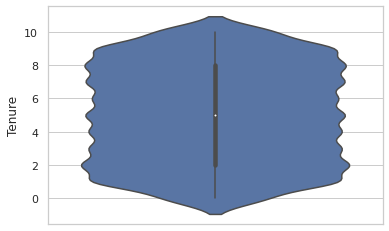

In [21]:
## Tenure
sns.violinplot(y = df_train['Tenure'])

<AxesSubplot:ylabel='Balance'>

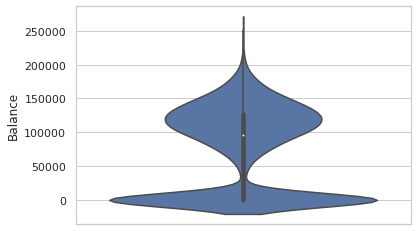

In [22]:
## Balance
sns.violinplot(y =df_train['Balance'])

<AxesSubplot:xlabel='NumOfProducts'>

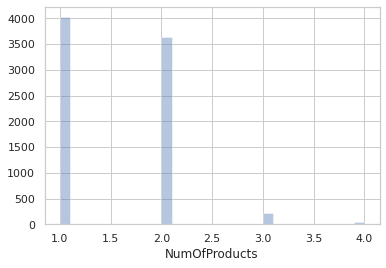

In [23]:
## NumberOfProduct
sns.distplot(df_train.NumOfProducts,hist =True, kde =False)

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Density'>

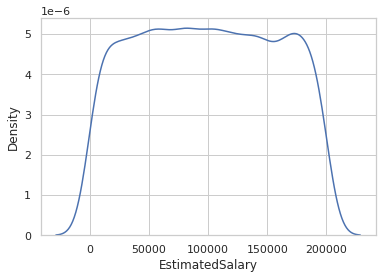

In [24]:
## EstimatedSalary
sns.kdeplot(df_train.EstimatedSalary)

### Missing values and outlier treatment

In [25]:
df_train.isnull().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [26]:
# making changes in temporary df
df_missing = df_train.copy()

In [27]:
## Modify few records to add missing values/outliers

#Introducing 10% nulls in Age
na_idx = df_missing.sample(frac = 0.1).index
df_missing.loc[na_idx, 'Age'] =np.NaN

#Introducing 30% nulls in Geography
na_idx = df_missing.sample(frac = 0.3).index
df_missing.loc[na_idx, 'Geography'] = np.NaN

# Introducitn 5% nulls in HasCrCard
na_idx = df_missing.sample(frac = 0.05).index
df_missing.loc[na_idx, 'HasCrCard'] = np.NaN

In [28]:
df_missing.isnull().sum()/df_missing.shape[0]

Surname            0.00
CreditScore        0.00
Geography          0.30
Gender             0.00
Age                0.10
Tenure             0.00
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.05
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

In [29]:
# Calculate mean statistis
age_mean = df_missing.Age.mean()

In [30]:
age_mean

38.81916386083053

In [31]:
# Filling nulls in Age by mean value (numerical column)
#df_missing['Age'].fillna(age_mean, inplace = True)

df_missing['Age'] = df_missing.Age.apply(lambda x: int(np.random.normal(age_mean, 3)) if np.isnan(x) else x)

<AxesSubplot:xlabel='Age', ylabel='Density'>

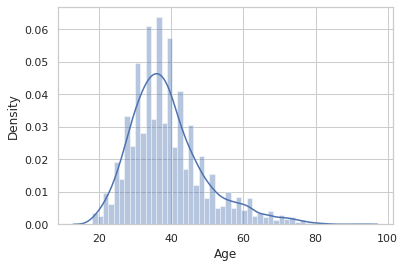

In [32]:
## Distribution of 'Age' feature before data imputation
sns.distplot(df_train.Age)

<AxesSubplot:xlabel='Age', ylabel='Density'>

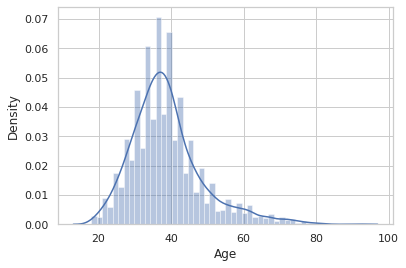

In [33]:
## Distribution of 'Age' feature after data imputation
sns.distplot(df_missing.Age)

In [34]:
# Filling nulls in Geography (categorical feature with a high %age of missing values)
geog_fill_value = 'UNK'
df_missing.Geography.fillna(geog_fill_value, inplace =True)

# Filling nulls in HasCrCard (boolean feature) - 0 for few nulls, -1 for lots of nulls
df_missing.HasCrCard.fillna(0, inplace=True)

In [35]:
df_missing.Geography.value_counts(normalize = True)

France     0.355934
UNK        0.300000
Germany    0.172980
Spain      0.171086
Name: Geography, dtype: float64

In [36]:
df_missing.isnull().sum()/df_missing.shape[0]

Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Gender Encoding

In [37]:
## The non-sklearn method
df_train['Gender_cat'] = df_train.Gender.astype('category').cat.codes

In [38]:
df_train.sample(10)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_cat
1265,Davidson,534,France,Female,55,8,116973.26,3,1,0,122066.50,1,0
4030,Evseev,603,Spain,Female,42,6,0.00,1,1,1,90437.87,0,0
5025,Shen,728,France,Male,37,3,122689.51,2,0,0,106977.53,1,1
6686,Yusupova,621,Spain,Male,50,3,163085.79,1,0,1,131048.36,0,1
1784,Gibson,658,France,Male,36,8,174060.46,1,1,1,94925.62,0,1
6836,Donnelly,715,Spain,Male,42,6,0.00,2,1,1,128745.69,0,1
7912,Buckley,642,France,Male,35,2,133161.95,1,0,1,122254.86,0,1
7998,Iloerika,829,Germany,Male,28,3,132405.52,3,1,0,104889.20,1,1
6564,Lawson,652,Germany,Female,47,0,126597.89,2,1,1,38798.79,1,0
9913,Chiedozie,718,France,Female,44,1,133866.22,1,0,1,139049.24,0,0


In [39]:
df_train.drop('Gender_cat', axis = 1, inplace =True)

In [40]:
df_train.sample(5)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1905,Gotch,535,Germany,Male,20,9,134874.40,1,1,1,118825.56,0
2228,Moss,644,France,Female,37,8,0.00,2,1,0,20968.88,0
9904,Angelo,690,Spain,Female,36,10,91760.11,1,1,1,135784.94,0
601,Mai,762,Spain,Female,26,7,123709.46,2,1,1,169654.57,0
4869,Coles,669,France,Male,50,4,149713.61,3,1,1,124872.42,1


In [41]:
## The sklearn method
from sklearn.preprocessing import LabelEncoder

In [42]:
le = LabelEncoder()

In [43]:
## Laebl encoding of Gender variable
df_train['Gender'] = le.fit_transform(df_train['Gender'])

In [44]:
## What if Gendetr column has new values in test or val set?
le.transform([['Male']])
#le.transform([['ABC']])

array([1])

In [45]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'Female': 0, 'Male': 1}

In [46]:
pd.Series(['ABC']).map(le_name_mapping)

0   NaN
dtype: float64

In [47]:
## Encoding Gender features for validation and test set
df_val['Gender'] = df_val.Gender.map(le_name_mapping)
df_test['Gender'] = df_test.Gender.map(le_name_mapping)

## Filling missing/NaN values created due to new categorical levels
df_val['Gender'].fillna(-1, inplace=True)
df_test['Gender'].fillna(-1, inplace= True)

In [48]:
df_train.Gender.unique(), df_val.Gender.unique(), df_test.Gender.unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

### One-Hot encoding for categorical variables with multiple levels

In [49]:
## The non-sklearn method
t = pd.get_dummies(df_train, prefix_sep = "_", columns = ['Geography'])
t.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
4562,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0,1,0
6498,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1,0,0
6072,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1,0,0
5813,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1,0,0
7407,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1,0,0


In [50]:
### Dropping dummy column
t.drop(['Geography_France'],axis = 1, inplace=True)
t.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
4562,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,1,0
6498,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,0,0
6072,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,0,0
5813,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,0,0
7407,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,0,0


In [51]:
## The sklearn method
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [52]:
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

In [53]:
enc_train = le_ohe.fit_transform(df_train.Geography).reshape(df_train.shape[0],1)
enc_train.shape
np.unique(enc_train)

(7920, 1)

array([0, 1, 2])

In [54]:
ohe_train =ohe.fit_transform(enc_train)
ohe_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [55]:
le_ohe_name_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_name_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

In [56]:
## Encoding Geography features for validation and test set
enc_val = df_val.Geography.map(le_ohe_name_mapping).ravel().reshape(-1, 1)
enc_test = df_test.Geography.map(le_ohe_name_mapping).ravel().reshape(-1, 1)

## Filling missing/NaN values created due to new categorical levels
enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999

In [57]:
np.unique(enc_val)
np.unique(enc_test)

array([0, 1, 2])

array([0, 1, 2])

In [58]:
ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

In [59]:
### Show what happens when a new value is inputted into the OHE
ohe.transform(np.array([[9999]]))

array([[0., 0., 0.]])

### Adding the one-hot encoded columns to the datafrom and removing the original feature

In [60]:
cols= ['country_' + str(x) for x in le_ohe_name_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [61]:
## Adding to the respective dataframes
df_train = pd.concat([df_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis = 1)
df_val = pd.concat([df_val.reset_index(), pd.DataFrame(ohe_val, columns =cols)], axis = 1).drop(['index'], axis =1)
df_test = pd.concat([df_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'],axis = 1)


In [62]:
print('Training set')
df_train.head()
print('\n\nValidation set')
df_val.head()
print('\n\nTest set')
df_test.head()

Training set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,Germany,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,France,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,France,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,France,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,France,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0




Validation set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Sun,757,France,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0
1,Russo,552,France,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0
2,Munro,619,France,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0
3,Perkins,633,France,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0
4,Aliyeva,698,Spain,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0




Test set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


In [63]:
## Drop the Geography column
df_train.drop(['Geography'], axis = 1, inplace=True)
df_val.drop(['Geography'], axis = 1, inplace=True)
df_test.drop(['Geography'], axis = 1, inplace=True)

### Target encoding

In [64]:
df_train.head()

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0


In [65]:
means =df_train.groupby(['Surname']).Exited.mean()
means.head()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

In [66]:
global_mean = y_train.mean()
global_mean

0.20303030303030303

In [67]:
## Creating new encoded features for surnance -target (mean) encoding
df_train['Surname_mean_churn'] = df_train.Surname.map(means)
df_train['Surname_mean_churn'].fillna(global_mean, inplace= True)

In [68]:
## Calculate frequency of each categoroy
freq = df_train.groupby(['Surname']).size()
freq.head()


Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

In [69]:
## Create frequency encoding -Number of instances of each category in the data
df_train['Surname_freq'] = df_train.Surname.map(freq)
df_train['Surname_freq'].fillna(0, inplace= True)


In [70]:
## Create Leave-one-out target encoding for Surname
df_train['Surname_enc'] = ((df_train.Surname_freq * df_train.Surname_mean_churn) - df_train.Exited)/(df_train.Surname_freq - 1)
df_train.head(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000
5,Miller,562,1,30,3,111099.79,2,0,0,140650.19,0,1.0,0.0,0.0,0.285714,14,0.307692
6,Padovesi,635,1,43,5,78992.75,2,0,0,153265.31,0,0.0,1.0,0.0,0.200000,10,0.222222
7,Edments,705,1,33,7,68423.89,1,1,1,64872.55,0,0.0,0.0,1.0,0.000000,1,NaN
8,Chan,694,1,42,8,133767.19,1,1,0,36405.21,0,1.0,0.0,0.0,0.000000,3,0.000000
9,Matthews,711,1,26,9,128793.63,1,1,0,19262.05,0,0.0,1.0,0.0,0.000000,4,0.000000


In [71]:
## Fill NaNs occuring due to category frequency being 1 or less
df_train['Surname_enc'].fillna((((df_train.shape[0] * global_mean) - df_train.Exited) / (df_train.shape[0] - 1)), inplace = True)
df_train.head(10)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000
5,Miller,562,1,30,3,111099.79,2,0,0,140650.19,0,1.0,0.0,0.0,0.285714,14,0.307692
6,Padovesi,635,1,43,5,78992.75,2,0,0,153265.31,0,0.0,1.0,0.0,0.200000,10,0.222222
7,Edments,705,1,33,7,68423.89,1,1,1,64872.55,0,0.0,0.0,1.0,0.000000,1,0.203056
8,Chan,694,1,42,8,133767.19,1,1,0,36405.21,0,1.0,0.0,0.0,0.000000,3,0.000000
9,Matthews,711,1,26,9,128793.63,1,1,0,19262.05,0,0.0,1.0,0.0,0.000000,4,0.000000


In [72]:
## Replacingby category means annd new category levels by global mean
df_val['Surname_enc'] = df_val.Surname.map(means)
df_val['Surname_enc'].fillna(global_mean, inplace =True)

df_test['Surname_enc'] = df_test.Surname.map(means)
df_test['Surname_enc'].fillna(global_mean, inplace =True)


In [73]:
## Show that using LOO target encoding decorrelates features
df_train[['Surname_mean_churn', 'Surname_enc','Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


In [74]:
### Deleting the 'Surname' and other redundant column across the three datasets
df_train.drop(['Surname_mean_churn', 'Surname_freq', 'Surname'], axis = 1, inplace = True)
df_val.drop(['Surname'], axis = 1, inplace = True)
df_test.drop(['Surname'], axis = 1, inplace =True)


In [75]:
df_train.head()
df_val.head()
df_test.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,757,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0,0.111111
1,552,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0,0.200000
2,619,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0,0.500000
3,633,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0,0.000000
4,698,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0,1.000000


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,596,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0,0.083333
1,623,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0,0.203030
2,601,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0,0.333333
3,506,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0,0.153846
4,560,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0,0.230769


In [76]:
corr = df_train.corr()
corr

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
CreditScore,1.000000,0.000354,0.002099,0.005994,-0.001507,0.014110,-0.011868,0.035057,0.000358,-0.028117,-0.009481,0.003393,0.007561,-0.000739
Gender,0.000354,1.000000,-0.024446,0.010749,0.009380,-0.026795,0.007550,0.028094,-0.011007,-0.102331,0.000823,-0.018412,0.017361,0.008002
Age,0.002099,-0.024446,1.000000,-0.011384,0.027721,-0.033305,-0.019633,0.093573,-0.006827,0.288221,-0.038881,0.048764,-0.003648,-0.010844
Tenure,0.005994,0.010749,-0.011384,1.000000,-0.013081,0.018231,0.026148,-0.021263,0.010145,-0.010660,0.000021,-0.003131,0.003090,-0.006753
Balance,-0.001507,0.009380,0.027721,-0.013081,1.000000,-0.304318,-0.021464,-0.008085,0.027247,0.113377,-0.231770,0.405616,-0.136044,0.006925
NumOfProducts,0.014110,-0.026795,-0.033305,0.018231,-0.304318,1.000000,0.007202,0.014809,0.009769,-0.039200,0.002991,-0.015926,0.012388,-0.002020
HasCrCard,-0.011868,0.007550,-0.019633,0.026148,-0.021464,0.007202,1.000000,-0.006526,-0.008413,-0.013659,0.005881,0.008197,-0.014934,-0.000551
IsActiveMember,0.035057,0.028094,0.093573,-0.021263,-0.008085,0.014809,-0.006526,1.000000,-0.016446,-0.152477,0.002126,-0.020570,0.018003,0.004902
EstimatedSalary,0.000358,-0.011007,-0.006827,0.010145,0.027247,0.009769,-0.008413,-0.016446,1.000000,0.015881,-0.004512,0.010583,-0.005320,-0.009899
Exited,-0.028117,-0.102331,0.288221,-0.010660,0.113377,-0.039200,-0.013659,-0.152477,0.015881,1.000000,-0.106006,0.173492,-0.050264,-0.026440


<AxesSubplot:>

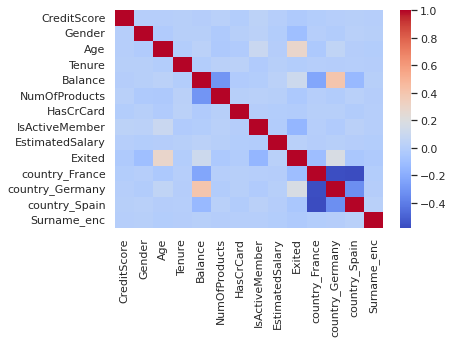

In [77]:
sns.heatmap(corr, cmap = 'coolwarm')

### Individual features versus their distribution across target variable values

<AxesSubplot:xlabel='Exited', ylabel='Age'>

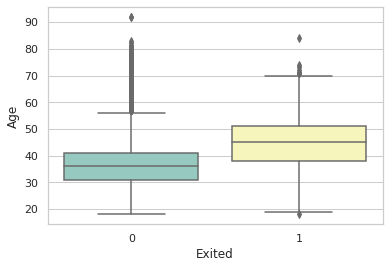

In [78]:
sns.boxplot(x = 'Exited', y ='Age', data = df_train, palette= 'Set3')

<AxesSubplot:xlabel='Exited', ylabel='Balance'>

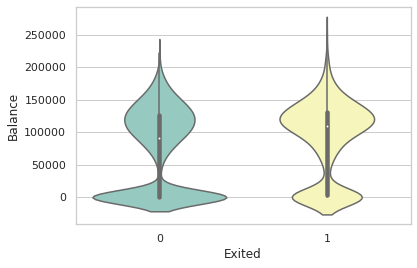

In [79]:
sns.violinplot(x = 'Exited', y = 'Balance', data = df_train, palette = 'Set3')

In [80]:
##Check association of categoriacal features with target variable
cat_vars_bv = ['Gender', 'IsActiveMember', 'country_Germany', 'country_France']

for col in cat_vars_bv:
    df_train.groupby([col]).Exited.mean()

Gender
0    0.248191
1    0.165511
Name: Exited, dtype: float64

IsActiveMember
0    0.266285
1    0.143557
Name: Exited, dtype: float64

country_Germany
0.0    0.163091
1.0    0.324974
Name: Exited, dtype: float64

country_France
0.0    0.245877
1.0    0.160593
Name: Exited, dtype: float64

In [81]:
col = 'NumOfProducts'
df_train.groupby([col]).Exited.mean()
df_train[col].value_counts()

NumOfProducts
1    0.273428
2    0.076881
3    0.825112
4    1.000000
Name: Exited, dtype: float64

1    4023
2    3629
3     223
4      45
Name: NumOfProducts, dtype: int64

### Some basic feature engineering

In [82]:
df_train.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'country_France', 'country_Germany', 'country_Spain', 'Surname_enc'],
      dtype='object')

In [83]:
eps = 10e-6

df_train['bal_per_product'] = df_train.Balance/(df_train.NumOfProducts + eps)
df_train['bal_by_est_salary'] = df_train.Balance/(df_train.EstimatedSalary + eps)
df_train['tenure_age_ratio'] = df_train.Tenure/(df_train.Age + eps)
df_train['age_surname_mean_churn'] = np.sqrt(df_train.Age) * df_train.Surname_enc


df_val['bal_per_product'] = df_val.Balance/(df_val.NumOfProducts + eps)
df_val['bal_by_est_salary'] = df_val.Balance/(df_val.EstimatedSalary + eps)
df_val['tenure_age_ratio'] = df_val.Tenure/(df_val.Age + eps)
df_val['age_surname_mean_churn'] = np.sqrt(df_val.Age) * df_val.Surname_enc

df_test['bal_per_product'] = df_test.Balance/(df_test.NumOfProducts + eps)
df_test['bal_by_est_salary'] = df_test.Balance/(df_test.EstimatedSalary + eps)
df_test['tenure_age_ratio'] = df_test.Tenure/(df_test.Age + eps)
df_test['age_surname_mean_churn'] = np.sqrt(df_test.Age) * df_test.Surname_enc

In [84]:
df_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,58932.130339,4.267519,0.027778,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,125166.488335,0.628653,0.185185,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.200000,1.490712
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000,0.000000,0.000000,0.166667,1.643168
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000,0.000000,0.000000,0.181818,2.345208


In [85]:
new_cols = ['bal_per_product', 'bal_by_est_salary','tenure_age_ratio','age_surname_mean_churn']

In [86]:
## Ensuring that the new column doesn;t have missing values
df_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

<AxesSubplot:>

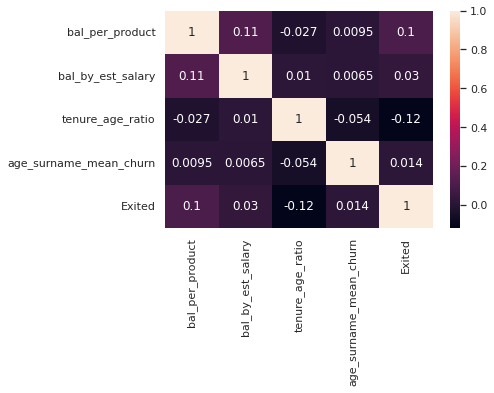

In [87]:
sns.heatmap(df_train[new_cols + ['Exited']].corr(), annot= True)

### Feature scaling and normalization

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Density'>

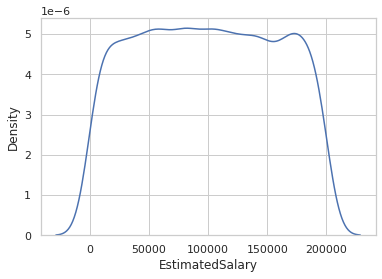

In [88]:
### Demoning feature transformations
sns.distplot(df_train.EstimatedSalary, hist= False)

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Density'>

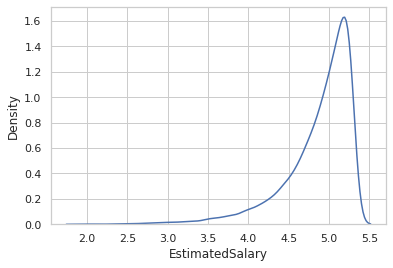

In [89]:
#sns.distplot(np.sqrt(df_train.EstimatedSalary), hist= False)
sns.distplot(np.log10(1 + df_train.EstimatedSalary), hist= False)

In [90]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [91]:
df_train.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'country_France', 'country_Germany', 'country_Spain', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

In [92]:
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','Surname_enc',
             'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']

cat_vars = ['Gender', 'HasCrCard','IsActiveMember','country_France', 'country_Germany', 'country_Spain']

In [93]:
#Scalling only continous columns
cols_to_scale = cont_vars

In [94]:
sc_X_train = sc.fit_transform(df_train[cols_to_scale])

In [95]:
## Converting from array to datafrom and naming the respectie features/columns
sc_X_train = pd.DataFrame(data = sc_X_train, columns = cols_to_scale)
sc_X_train.shape
sc_X_train.head()

(7920, 11)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062386,0.095448,-1.232035,-1.062507
1,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104839,-0.118834,0.525547,-1.062507
2,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100926,-0.155854,0.690967,0.193191
3,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100926,-0.155854,0.318772,0.321611
4,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100926,-0.155854,0.487951,0.912973


In [96]:
sc_X_train.Balance.mean()

-9.420074148334662e-17

In [97]:
## Mapping learnt on the continous features
sc_map = {'mean': sc.mean_, 'std':np.sqrt(sc.var_)}
sc_map

{'mean': array([6.50542424e+02, 3.88912879e+01, 5.01376263e+00, 7.60258447e+04,
        1.53156566e+00, 9.96616540e+04, 2.04321788e-01, 6.24722156e+04,
        2.64665645e+00, 1.38117653e-01, 1.26136416e+00]),
 'std': array([9.64231806e+01, 1.05374237e+01, 2.88940724e+00, 6.23738902e+04,
        5.82587032e-01, 5.74167173e+04, 1.89325378e-01, 5.67451530e+04,
        1.69816780e+01, 8.95590379e-02, 1.18715858e+00])}

In [98]:
cols_to_scale

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [99]:
## Scaling validation and test sets by transforming the mapping obtained through the training set
sc_X_val = sc.transform(df_val[cols_to_scale])
sc_X_test = sc.transform(df_test[cols_to_scale])

In [100]:
## Converting val and test arrays to datafromes for re-usability
sc_X_val = pd.DataFrame(data = sc_X_val, columns = cols_to_scale)
sc_X_test = pd.DataFrame(data = sc_X_test, columns = cols_to_scale)


### Feature selection

In [101]:
cont_vars
cat_vars

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain']

In [102]:
## Creating features-set and target for RFE model
y = df_train['Exited'].values
X = pd.concat([df_train[cat_vars], sc_X_train[cont_vars]], ignore_index = True, axis = 1)
# X = df_train[cat_vars + cont_vars]
X.columns = cat_vars + cont_vars


In [103]:
X.head()

,Gender,HasCrCard,IsActiveMember,country_France,country_Germany,country_Spain,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,1,1,0,0.0,1.0,0.0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062386,0.095448,-1.232035,-1.062507
1,0,1,0,1.0,0.0,0.0,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104839,-0.118834,0.525547,-1.062507
2,1,1,1,1.0,0.0,0.0,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100926,-0.155854,0.690967,0.193191
3,1,1,0,1.0,0.0,0.0,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100926,-0.155854,0.318772,0.321611
4,1,1,0,1.0,0.0,0.0,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100926,-0.155854,0.487951,0.912973


In [104]:
from sklearn.feature_selection import RFE  ## Recursive Feature Elimination
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [105]:
#est = LogisticRegression()
est = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
num_features_to_select = 10

In [106]:
rfe = RFE(est, n_features_to_select = num_features_to_select)
rfe = rfe.fit(X.values, y)
print(rfe.support_)
print(rfe.ranking_)

[False False  True False  True False False  True False False  True  True
  True  True  True  True  True]
[8 7 1 6 1 5 4 1 3 2 1 1 1 1 1 1 1]


In [107]:
X.columns

Index(['Gender', 'HasCrCard', 'IsActiveMember', 'country_France',
       'country_Germany', 'country_Spain', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

In [108]:
## Logistic Regression(Linear model)
mask =rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [109]:
## Decision Tree (Non-linear model)
mask = rfe.support_.tolist()
selected_feats_dt = [b for a, b in zip(mask, X.columns) if a]
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

### Baseline model: Logistic Regression

train linear models on the features selected through RFE

In [110]:
from sklearn.linear_model import LogisticRegression

In [111]:
## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [112]:
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]

In [113]:
df_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,58932.130339,4.267519,0.027778,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,125166.488335,0.628653,0.185185,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.200000,1.490712
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000,0.000000,0.000000,0.166667,1.643168
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000,0.000000,0.000000,0.181818,2.345208


In [114]:
## Using categorical features and scaled numerical features
X_train = np.concatenate((df_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis = 1)
X_val =np.concatenate((df_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis = 1)
X_test = np.concatenate((df_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis = 1)

X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

In [115]:
np.unique(y_train, return_counts = True)

(array([0, 1]), array([6312, 1608]))

In [116]:
# obtaining class weights based on the class samples imbalanced ratio
_, num_samples = np.unique(y_train, return_counts = True)
weights = np.max(num_samples)/num_samples
weights
num_samples

array([1.        , 3.92537313])

array([6312, 1608])

In [117]:
weights_dict = dict()
class_labels = [0, 1]
for a, b in zip(class_labels, weights):
    weights_dict[a] = b
    
weights_dict    
    

{0: 1.0, 1: 3.925373134328358}

In [120]:
## Defining model
lr = LogisticRegression(C = 1.0, penalty = 'l2', class_weight = weights_dict, n_jobs = -1)

In [121]:
lr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

In [122]:
#Fitted model parameters
selected_cat_vars + selected_cont_vars

lr.coef_
lr.intercept_

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

array([[-0.91141317,  0.79162817,  0.82241677,  0.0189563 ,  0.04631983,
         0.01794672,  0.13797139,  0.03350431, -0.05619757, -0.08196842]])

array([0.00465975])

In [124]:
## Training metrics
roc_auc_score(y_train, lr.predict(X_train))
recall_score(y_train, lr.predict(X_train))
confusion_matrix(y_train, lr.predict(X_train))
print(classification_report(y_train, lr.predict(X_train)))

0.7028013449860961

0.6902985074626866

array([[4515, 1797],
       [ 498, 1110]])

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      6312
           1       0.38      0.69      0.49      1608

    accuracy                           0.71      7920
   macro avg       0.64      0.70      0.64      7920
weighted avg       0.80      0.71      0.74      7920



In [125]:
## Validation metrics
roc_auc_score(y_val, lr.predict(X_val))
recall_score(y_val, lr.predict(X_val))
confusion_matrix(y_val, lr.predict(X_val))
print(classification_report(y_val, lr.predict(X_val)))

0.6931575480548515

0.6974789915966386

array([[580, 262],
       [ 72, 166]])

              precision    recall  f1-score   support

           0       0.89      0.69      0.78       842
           1       0.39      0.70      0.50       238

    accuracy                           0.69      1080
   macro avg       0.64      0.69      0.64      1080
weighted avg       0.78      0.69      0.72      1080



In [126]:
## Validation metrics
roc_auc_score(y_test, lr.predict(X_test))
recall_score(y_test, lr.predict(X_test))
confusion_matrix(y_test, lr.predict(X_test))
print(classification_report(y_test, lr.predict(X_test)))

0.7109255172503058

0.7172774869109948

array([[570, 239],
       [ 54, 137]])

              precision    recall  f1-score   support

           0       0.91      0.70      0.80       809
           1       0.36      0.72      0.48       191

    accuracy                           0.71      1000
   macro avg       0.64      0.71      0.64      1000
weighted avg       0.81      0.71      0.74      1000



### More linear models -SVM

In [127]:
from sklearn.svm import SVC

## importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [130]:
## Using categorical features and scaled numerical features
X_train = np.concatenate((df_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis = 1)
X_val = np.concatenate((df_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values),axis = 1)
X_test =np.concatenate((df_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis = 1)

X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

In [131]:
weights_dict = {0:1.0, 1: 3.92}
weights_dict

{0: 1.0, 1: 3.92}

In [132]:
svm = SVC(C = 1.0, kernel = 'linear', class_weight = weights_dict)

In [133]:
svm.fit(X_train, y_train)

SVC(class_weight={0: 1.0, 1: 3.92}, kernel='linear')

In [136]:
## Fitted model parameters
selected_cat_vars + selected_cont_vars

svm.coef_
svm.intercept_

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

array([[-0.73232009,  0.76506603,  0.91774614,  0.03250184,  0.0420893 ,
         0.02183078,  0.1113956 ,  0.0207103 , -0.02365979, -0.08353827]])

array([-0.09921028])

In [137]:
## Training metrics
roc_auc_score(y_train, svm.predict(X_train))
recall_score(y_train, svm.predict(X_train))
confusion_matrix(y_train, svm.predict(X_train))
print(classification_report(y_train, svm.predict(X_train)))

0.7084172767341997

0.6828358208955224

array([[4633, 1679],
       [ 510, 1098]])

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      6312
           1       0.40      0.68      0.50      1608

    accuracy                           0.72      7920
   macro avg       0.65      0.71      0.65      7920
weighted avg       0.80      0.72      0.75      7920



In [138]:
## Validation metrics
roc_auc_score(y_val, svm.predict(X_val))
recall_score(y_val, svm.predict(X_val))
confusion_matrix(y_val, svm.predict(X_val))
print(classification_report(y_val, svm.predict(X_val)))

0.6864458372422604

0.6638655462184874

array([[597, 245],
       [ 80, 158]])

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       842
           1       0.39      0.66      0.49       238

    accuracy                           0.70      1080
   macro avg       0.64      0.69      0.64      1080
weighted avg       0.77      0.70      0.72      1080



In [139]:
## testing metrics
roc_auc_score(y_test, svm.predict(X_test))
recall_score(y_test, svm.predict(X_test))
confusion_matrix(y_test, svm.predict(X_test))
print(classification_report(y_test, svm.predict(X_test)))

0.7266679178612339

0.7277486910994765

array([[587, 222],
       [ 52, 139]])

              precision    recall  f1-score   support

           0       0.92      0.73      0.81       809
           1       0.39      0.73      0.50       191

    accuracy                           0.73      1000
   macro avg       0.65      0.73      0.66      1000
weighted avg       0.82      0.73      0.75      1000



### More basedline models (Non-Linear): Desicion Tree

In [141]:
from sklearn.tree import DecisionTreeClassifier

##importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [142]:
weights_dict = {0:1.0, 1:3.92}
weights_dict

{0: 1.0, 1: 3.92}

In [140]:
## features selected from the RFE process
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [143]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train[selected_feats_dt].values
X_val = df_val[selected_feats_dt].values
X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 10), (7920,))

((1080, 10), (1080,))

In [145]:
clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 4, max_features = None,
                            min_samples_split =25, min_samples_leaf = 15)

In [146]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=4, min_samples_leaf=15, min_samples_split=25)

In [154]:
## Checking the importance of different features of the model
pd.DataFrame({'features':selected_feats,
            'importance':clf.feature_importances_
            }).sort_values(by = 'importance', ascending = False)

,features,importance
2,Age,0.476857
3,NumOfProducts,0.351836
0,IsActiveMember,0.096427
7,bal_by_est_salary,0.043623
1,country_Germany,0.028357
4,EstimatedSalary,0.002900
5,Surname_enc,0.000000
6,bal_per_product,0.000000
8,tenure_age_ratio,0.000000
9,age_surname_mean_churn,0.000000


### Evaluating the model -Metrics

In [149]:
## Training metrics
roc_auc_score(y_train, clf.predict(X_train))
recall_score(y_train, clf.predict(X_train))
confusion_matrix(y_train, clf.predict(X_train))
print(classification_report(y_train, clf.predict(X_train)))


0.7514707829672929

0.7369402985074627

array([[4835, 1477],
       [ 423, 1185]])

              precision    recall  f1-score   support

           0       0.92      0.77      0.84      6312
           1       0.45      0.74      0.56      1608

    accuracy                           0.76      7920
   macro avg       0.68      0.75      0.70      7920
weighted avg       0.82      0.76      0.78      7920



In [150]:
## Validation metrics
roc_auc_score(y_val, clf.predict(X_val))
recall_score(y_val, clf.predict(X_val))
confusion_matrix(y_val, clf.predict(X_val))
print(classification_report(y_val, clf.predict(X_val)))

0.7477394758378411

0.7436974789915967

array([[633, 209],
       [ 61, 177]])

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080



### Plot decision boundaries of non-linear model

In [155]:
from sklearn.decomposition import PCA

In [157]:
pca = PCA(n_components = 2)

In [158]:
## Transforming the dataset using PCA
X = pca.fit_transform(X_train)
y = y_train
X_train.shape
X.shape
y.shape


(7920, 10)

(7920, 2)

(7920,)

In [159]:
## Checking the variance explained by the reduced features
pca.explained_variance_ratio_

array([0.51070166, 0.48929828])

In [162]:
# Creating a mesh region where the boundary will be plotted
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 100),
                    np.arange(y_min, y_max, 100))
 

In [165]:
## Fitting tree model on 2 features
clf.fit(X, y)



DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=4, min_samples_leaf=15, min_samples_split=25)

<AxesSubplot:>

Text(0.5, 1.0, 'Decision Tree')

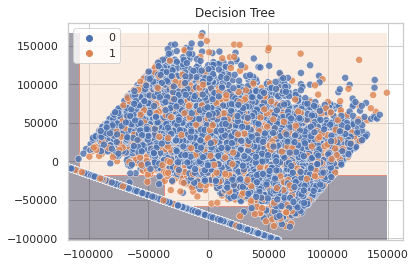

In [171]:
## Plotting decision boundary for LR
z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

## Displaying the result
plt.contourf(xx, yy, z, alpha = 0.4) #DT
sns.scatterplot(X[:, 0], X[:,1], hue = y_train, s = 50, alpha = 0.8)
plt.title('Decision Tree')

### Decision tree rule engine visualization

In [173]:
from sklearn.tree import export_graphviz
import subprocess

In [175]:
clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 3, max_features = None,
                            min_samples_split = 25, min_samples_leaf = 15)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92}, criterion='entropy',
                       max_depth=3, min_samples_leaf=15, min_samples_split=25)

In [177]:
## Export as dot file
dot_data = export_graphviz(clf, out_file = 'tree.dot',
                          feature_names = selected_feats_dt,
                          class_names = ['Did not churn', 'Churned'],
                          rounded = True, proportion = False,
                          precision = 2, filled = True)

In [189]:
from sklearn import tree
tree.export_graphviz(clf)

'digraph Tree {\nnode [shape=box, fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="X[2] <= 2.45\\ngini = 0.667\\nsamples = 150\\nvalue = [50, 50, 50]"] ;\n1 [label="gini = 0.0\\nsamples = 50\\nvalue = [50, 0, 0]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="X[3] <= 1.75\\ngini = 0.5\\nsamples = 100\\nvalue = [0, 50, 50]"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n3 [label="X[2] <= 4.95\\ngini = 0.168\\nsamples = 54\\nvalue = [0, 49, 5]"] ;\n2 -> 3 ;\n4 [label="X[3] <= 1.65\\ngini = 0.041\\nsamples = 48\\nvalue = [0, 47, 1]"] ;\n3 -> 4 ;\n5 [label="gini = 0.0\\nsamples = 47\\nvalue = [0, 47, 0]"] ;\n4 -> 5 ;\n6 [label="gini = 0.0\\nsamples = 1\\nvalue = [0, 0, 1]"] ;\n4 -> 6 ;\n7 [label="X[3] <= 1.55\\ngini = 0.444\\nsamples = 6\\nvalue = [0, 2, 4]"] ;\n3 -> 7 ;\n8 [label="gini = 0.0\\nsamples = 3\\nvalue = [0, 0, 3]"] ;\n7 -> 8 ;\n9 [label="X[0] <= 6.95\\ngini = 0.444\\nsamples = 3\\nvalue = [0, 2, 1]"] ;\n7 -> 

In [190]:
## Convert to png using system command (requires Graphviz)
subprocess.run(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])


FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

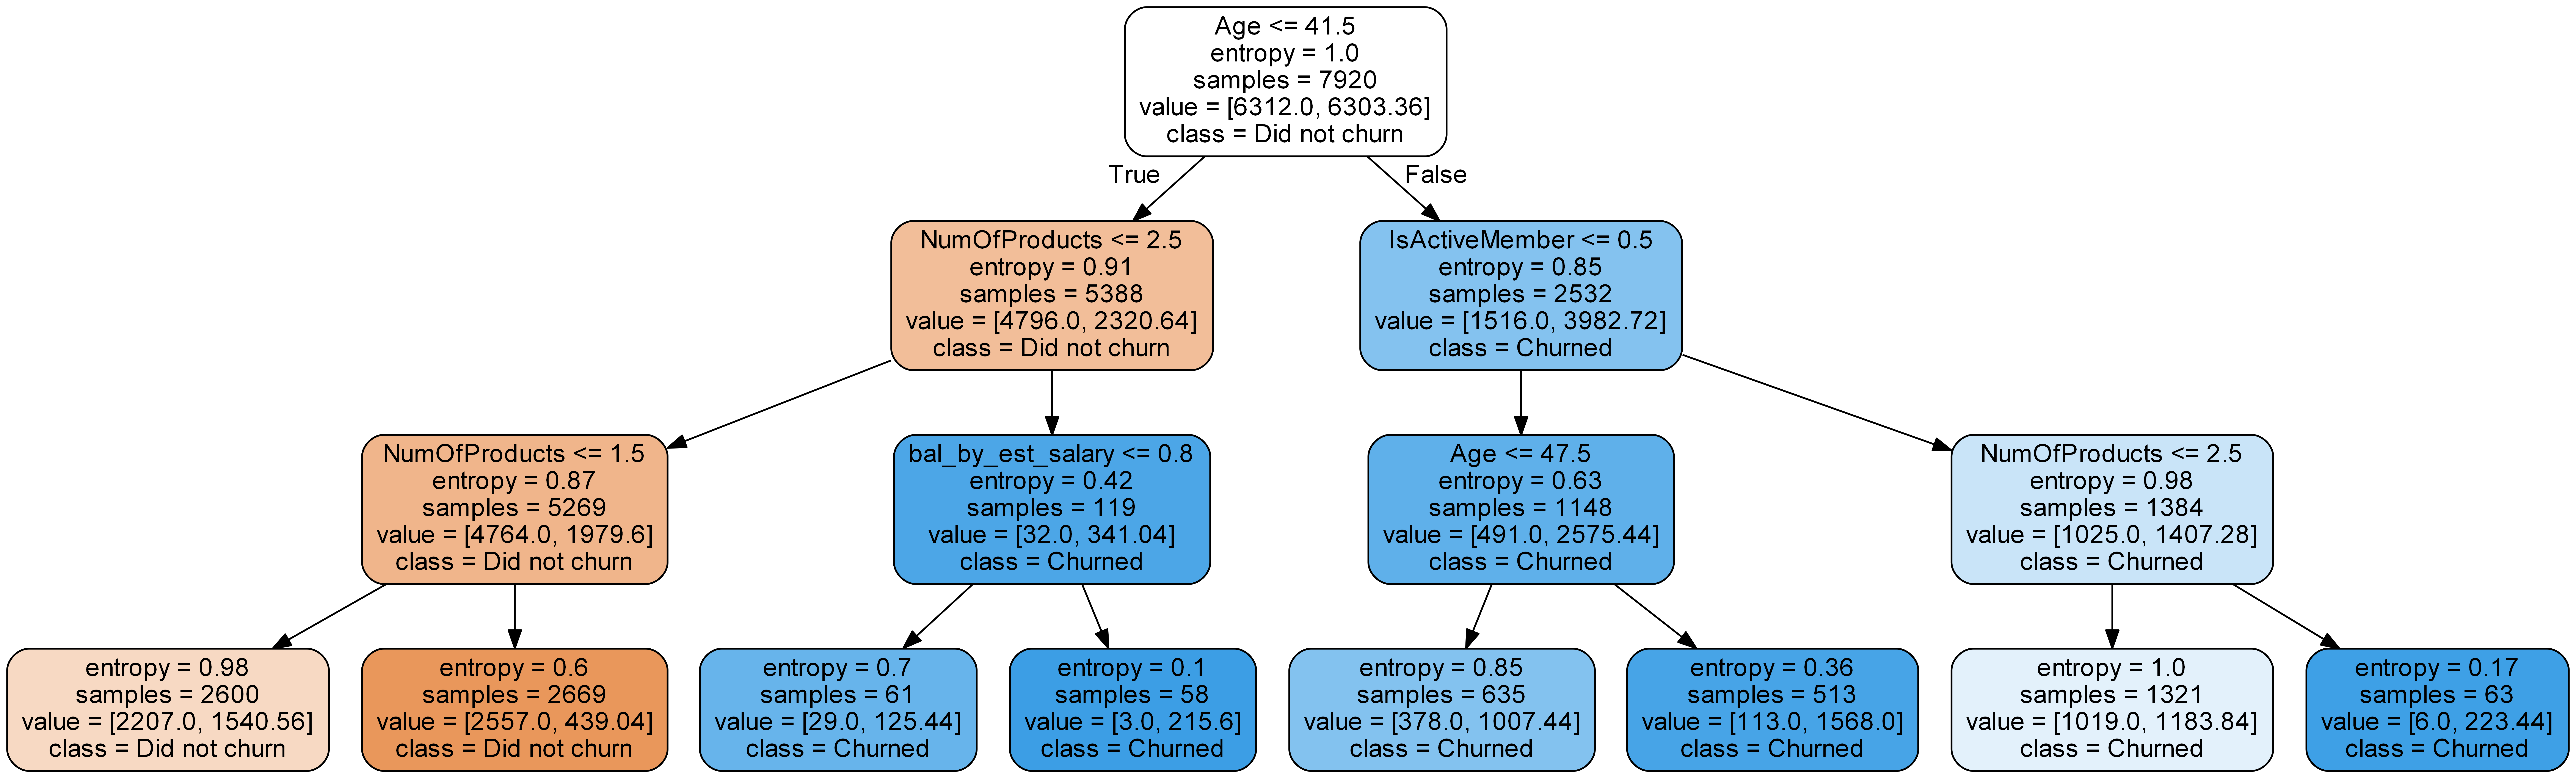

In [204]:
## Display the rule-set of a single tree
from IPython.display import Image
Image(filename = 'img/tree.png')

### Spot checking various ML algorithms

automating data preparation and model run through Pipelines

In [207]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """ 
    Encodes categorical columns using LabelEncoding, OneHotEncoding and TargetEncoding.
    LabelEncoding is used for binary categorical columns
    OneHotEncoding is used for columns with <= 10 distinct values
    TargetEncoding is used for columns with higher cardinality (>10 distinct values)
    
    """

    def __init__(self, cols = None, lcols = None, ohecols = None, tcols = None, reduce_df = False):
        """
        
        Parameters
        ----------
        cols : list of str
            Columns to encode.  Default is to one-hot/target/label encode all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to use reduced degrees of freedom for encoding
            (that is, add N-1 one-hot columns for a column with N 
            categories). E.g. for a column with categories A, B, 
            and C: When reduce_df is True, A=[1, 0], B=[0, 1],
            and C=[0, 0].  When reduce_df is False, A=[1, 0, 0], 
            B=[0, 1, 0], and C=[0, 0, 1]
            Default = False
        
        """
        
        if isinstance(cols,str):
            self.cols = [cols]
        else :
            self.cols = cols
        
        if isinstance(lcols,str):
            self.lcols = [lcols]
        else :
            self.lcols = lcols
        
        if isinstance(ohecols,str):
            self.ohecols = [ohecols]
        else :
            self.ohecols = ohecols
        
        if isinstance(tcols,str):
            self.tcols = [tcols]
        else :
            self.tcols = tcols
        
        self.reduce_df = reduce_df
    
    
    def fit(self, X, y):
        """Fit label/one-hot/target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')
        
        # Separating out lcols, ohecols and tcols
        if self.lcols is None:
            self.lcols = [c for c in self.cols if X[c].nunique() <= 2]
        
        if self.ohecols is None:
            self.ohecols = [c for c in self.cols if ((X[c].nunique() > 2) & (X[c].nunique() <= 10))]
        
        if self.tcols is None:
            self.tcols = [c for c in self.cols if X[c].nunique() > 10]
        
        
        ## Create Label Encoding mapping
        self.lmaps = dict()
        for col in self.lcols:
            self.lmaps[col] = dict(zip(X[col].values, X[col].astype('category').cat.codes.values))
        
        
        ## Create OneHot Encoding mapping
        self.ohemaps = dict() #dict to store map for each column
        for col in self.ohecols:
            self.ohemaps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.ohemaps[col].append(unique)
            if self.reduce_df:
                del self.ohemaps[col][-1]
        
        
        ## Create Target Encoding mapping
        self.global_target_mean = y.mean().round(2)
        self.sum_count = dict()
        for col in self.tcols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = (y[ix].sum(),ix.sum())
        
        
        ## Return the fit object
        return self
    
    
    def transform(self, X, y=None):
        """Perform label/one-hot/target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        Xo = X.copy()
        ## Perform label encoding transformation
        for col, lmap in self.lmaps.items():
            
            # Map the column
            Xo[col] = Xo[col].map(lmap)
            Xo[col].fillna(-1, inplace=True) ## Filling new values with -1
        
        
        ## Perform one-hot encoding transformation
        for col, vals in self.ohemaps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        
        
        ## Perform LOO target encoding transformation
        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = (sum_count[0]/sum_count[1]).round(2)
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    if sum_count[1] > 1:
                        vals[ix] = ((sum_count[0]-y[ix].reshape(-1,))/(sum_count[1]-1)).round(2)
                    else :
                        vals[ix] = ((y.sum() - y[ix])/(X.shape[0] - 1)).round(2) # Catering to the case where a particular 
                                                                                 # category level occurs only once in the dataset
                
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean
        
        
        ## Return encoded DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label/one-hot/target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        return self.fit(X, y).transform(X, y)
    
